### PNEUMONIA  CLASSIFICATION

![](xray.jpg)

This project focuses on image classification using convolutional neural networks (CNNs) to determine whether a chest X-ray image indicates the presence of pneumonia in a human. Chest X-rays are commonly used to diagnose pneumonia, a lung infection that can be life-threatening if not treated promptly. By training the CNN on a dataset of chest X-ray images labeled as pneumonia-positive or pneumonia-negative, the model learns to recognize patterns indicative of the disease. This automated classification system could potentially assist healthcare professionals in faster and more accurate diagnosis, leading to better patient outcomes.







In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot  as plt


In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5856 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [6]:
class_names.index("NORMAL")

0

In [7]:
len(dataset)

183

In [8]:
183*32 #Because we have 32 images in each batch.

5856

In [98]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0]


In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[48.       48.       48.      ]
  [48.       48.       48.      ]
  [48.       48.       48.      ]
  ...
  [34.       34.       34.      ]
  [34.       34.       34.      ]
  [34.       34.       34.      ]]

 [[48.       48.       48.      ]
  [48.       48.       48.      ]
  [48.       48.       48.      ]
  ...
  [33.       33.       33.      ]
  [33.       33.       33.      ]
  [33.       33.       33.      ]]

 [[48.       48.       48.      ]
  [47.743652 47.743652 47.743652]
  [47.21875  47.21875  47.21875 ]
  ...
  [32.78125  32.78125  32.78125 ]
  [32.78125  32.78125  32.78125 ]
  [32.78125  32.78125  32.78125 ]]

 ...

 [[14.194824 14.194824 14.194824]
  [70.08984  70.08984  70.08984 ]
  [65.21875  65.21875  65.21875 ]
  ...
  [49.78125  49.78125  49.78125 ]
  [53.98047  53.98047  53.98047 ]
  [12.806152 12.806152 12.806152]]

 [[65.       65.       65.      ]
  [66.       66.       66.      ]
  [66.       66.       66.      ]
  ...
  [49.       49.       49. 

As you see this is tensor if we want to see this like numpy we just write .numpy().

### Visualizing images

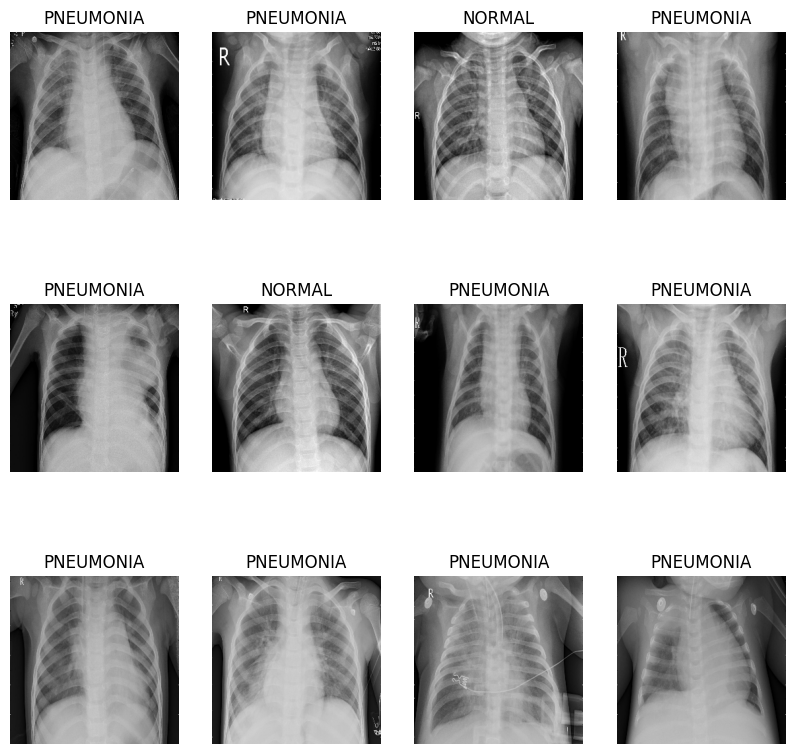

In [11]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Train test validation

In [12]:
train_size = 0.8 
len(dataset)

183

In [13]:
len(dataset)*train_size

146.4

In [14]:
train_ds = dataset.take(146)

In [15]:
test_ds = dataset.skip(146)
len(test_ds)

37

In [16]:
val_size = 0.1
len(dataset)*val_size

18.3

In [17]:
val_ds = test_ds.take(18)
len(val_ds)

18

In [18]:
test_ds =test_ds.skip(18)
len(test_ds)

19

In [19]:
def dataset_partition(ds,train_split = 0.8,test_split = 0.1 ,val_split = 0.1,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [20]:
train_ds,val_ds,test_ds =dataset_partition(dataset)

In [21]:
len(train_ds)

146

In [22]:
len(test_ds)

19

In [23]:
len(val_ds)

18

In [24]:
class_distribution = {}
for image_batch, label_batch in train_ds:
    labels = label_batch.numpy()  # Convert label_batch to a NumPy array if it's not already
    unique_labels, counts = np.unique(labels, return_counts=True)

    for label, count in zip(unique_labels, counts):
        class_name = class_names[label]
        class_distribution[class_name] = class_distribution.get(class_name, 0) + count

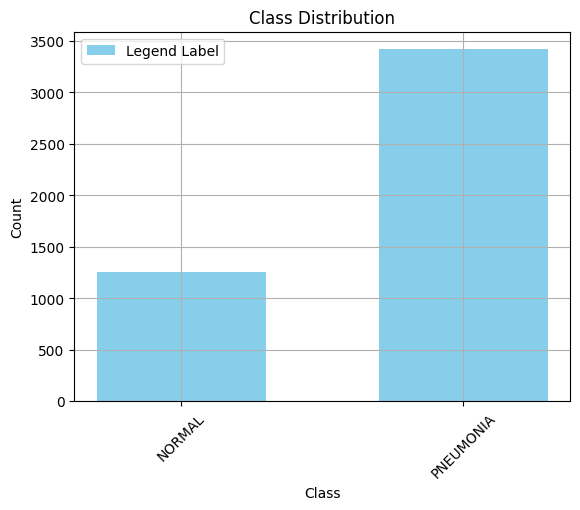

In [25]:
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue', width=0.6)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)  
plt.grid(True)  
plt.legend(['Legend Label'])  
plt.show()

### We have balance problem.

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
])

In [27]:
normal_class = []
pneumonia_class = []
for images, labels in train_ds:
    for image, label in zip(images, labels):
        if label == 0:
            normal_class.append(image.numpy())
        else:
            pneumonia_class.append(image.numpy())

In [28]:
augmented_normal_class = [data_augmentation(image) for image in normal_class]

In [29]:
augmented_normal_class = normal_class + augmented_normal_class


In [30]:
len(augmented_normal_class)

2580

In [31]:
len(pneumonia_class)

3382

In [32]:
normal_ds = tf.data.Dataset.from_tensor_slices((augmented_normal_class, [0] * len(augmented_normal_class)))
pneumonia_ds = tf.data.Dataset.from_tensor_slices((pneumonia_class, [1] * len(pneumonia_class)))
train_ds = normal_ds.concatenate(pneumonia_ds)


In [33]:
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)

### Cache, Shuffle, and Prefetch the Dataset

In [34]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [35]:
class_distribution = {}
for image_batch, label_batch in train_ds:
    labels = label_batch.numpy()  # Convert label_batch to a NumPy array if it's not already
    unique_labels, counts = np.unique(labels, return_counts=True)

    for label, count in zip(unique_labels, counts):
        class_name = class_names[label]
        class_distribution[class_name] = class_distribution.get(class_name, 0) + count

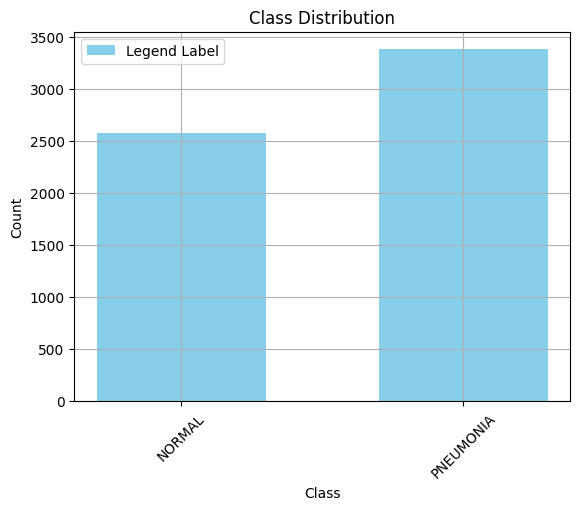

In [36]:
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue', width=0.6)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)  
plt.grid(True)  
plt.legend(['Legend Label'])  
plt.show()

### Scaling

In [37]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),  
])

model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

![](binary.jpg)

In [42]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
187/187 [==============================] - 272s 1s/step - loss: 0.5917 - accuracy: 0.6847 - val_loss: 0.3594 - val_accuracy: 0.8420
Epoch 2/10
187/187 [==============================] - 227s 1s/step - loss: 0.4055 - accuracy: 0.8261 - val_loss: 0.3189 - val_accuracy: 0.8785
Epoch 3/10
187/187 [==============================] - 219s 1s/step - loss: 0.2989 - accuracy: 0.8807 - val_loss: 0.3009 - val_accuracy: 0.8646
Epoch 4/10
187/187 [==============================] - 218s 1s/step - loss: 0.2165 - accuracy: 0.9161 - val_loss: 0.1717 - val_accuracy: 0.9375
Epoch 5/10
187/187 [==============================] - 218s 1s/step - loss: 0.1738 - accuracy: 0.9351 - val_loss: 0.2147 - val_accuracy: 0.9045
Epoch 6/10
187/187 [==============================] - 219s 1s/step - loss: 0.1386 - accuracy: 0.9452 - val_loss: 0.1381 - val_accuracy: 0.9479
Epoch 7/10
187/187 [==============================] - 216s 1s/step - loss: 0.1207 - accuracy: 0.9517 - val_loss: 0.2241 - val_accuracy: 0.9149

In [44]:
model.evaluate(test_ds)

19/19 [==============================] - 17s 290ms/step - loss: 0.0864 - accuracy: 0.9688


[0.08635035902261734, 0.96875]

In [45]:
acc =history.history["accuracy"]
val_acc= history.history["val_accuracy"]
loss =history.history["loss"]
val_loss =history.history["val_loss"]

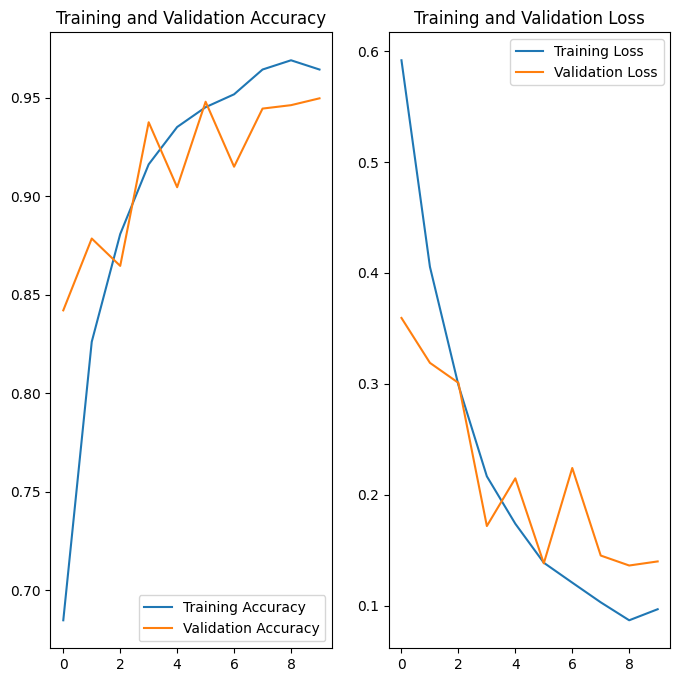

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict


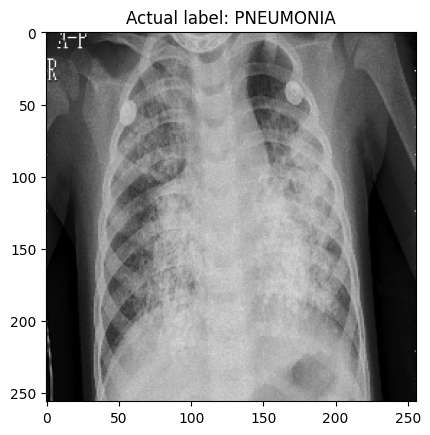

1/1 [==============================] - 0s 277ms/step
Predicted label: PNEUMONIA


In [85]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.title("Actual label: " + class_names[first_label])
    plt.show()
    
    batch_prediction = model.predict(images_batch)
    predicted_label = 1 if batch_prediction[0] > 0.5 else 0
    print("Predicted label:", class_names[predicted_label])


In [88]:
pred = model.predict(test_ds)

19/19 [==============================] - 5s 245ms/step


In [89]:
pred

array([[3.10486555e-03],
       [1.42029850e-02],
       [9.99973118e-01],
       [2.29288102e-03],
       [9.99946594e-01],
       [7.29673193e-05],
       [9.99998212e-01],
       [3.77239822e-03],
       [9.99315500e-01],
       [9.92368698e-01],
       [9.99933660e-01],
       [1.00909992e-05],
       [9.99966860e-01],
       [8.91001284e-01],
       [9.93059039e-01],
       [9.99999583e-01],
       [9.50841486e-01],
       [9.65626459e-05],
       [9.99366283e-01],
       [9.99865353e-01],
       [9.99977767e-01],
       [9.99907076e-01],
       [9.79354084e-01],
       [9.38190997e-01],
       [9.93729651e-01],
       [9.99977410e-01],
       [9.10176277e-01],
       [1.37877348e-03],
       [7.08348036e-01],
       [9.01571984e-05],
       [5.63480286e-03],
       [4.28593487e-01],
       [1.57035485e-01],
       [1.64771092e-03],
       [9.99999821e-01],
       [9.99874830e-01],
       [9.99737322e-01],
       [4.06066147e-06],
       [9.99302566e-01],
       [9.99999821e-01],


In [103]:
true_labels

[1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,


In [112]:
from sklearn.metrics import confusion_matrix,classification_report


In [105]:
true_labels = []
predicted_binary_labels = []

for images_batch, labels_batch in test_ds:
    batch_predictions = model.predict(images_batch)
    
    for i in range(len(images_batch)):
        true_label = labels_batch[i].numpy()
        predicted_label = 1 if batch_predictions[i] >= 0.5 else 0
        
        true_labels.append(true_label)
        predicted_binary_labels.append(predicted_label)

1/1 [==============================] - 0s 257ms/step


In [120]:
for i,j in test_ds:
    print(len(i))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32


In [106]:
true_labels

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,


In [107]:
predicted_binary_labels

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,


In [109]:
report = classification_report(true_labels,predicted_binary_labels)

In [111]:
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       187
           1       0.98      0.97      0.98       421

    accuracy                           0.97       608
   macro avg       0.96      0.97      0.96       608
weighted avg       0.97      0.97      0.97       608



![](pr.jpg)

In [113]:
confusion = confusion_matrix(true_labels, predicted_binary_labels)

print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[180   7]
 [ 12 409]]


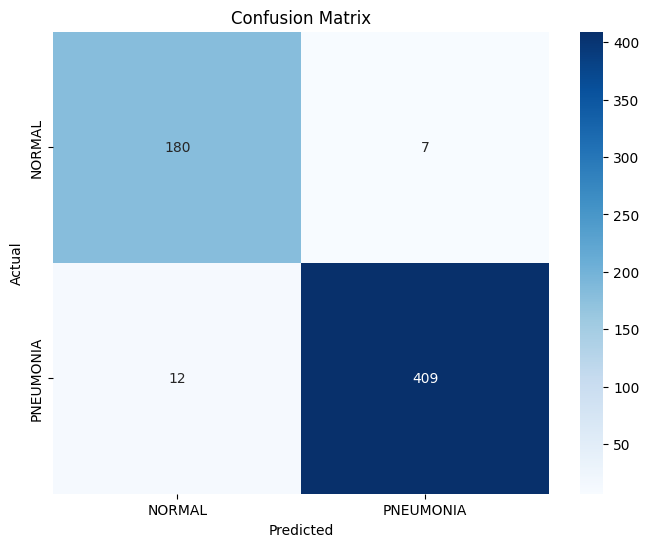

In [114]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

![](conff.jpg)

In [115]:
model.save("last_model.h5")

C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
